In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
import pickle
import ast
import sklearn
from math import *
from sklearn.cluster import KMeans
import random
from sklearn.metrics.pairwise import euclidean_distances
import numpy.matlib
import seaborn as sns

In [84]:
#Useful functions to save and load files in pickle format
def save_dict(obj, name ):
    with open(f'{name}.pickle', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name ):
    with open(f'{name}.pickle', 'rb') as f:
        return pickle.load(f)

In [85]:
reviews_per_product = load_obj('new_data') 

In [50]:
d = pd.read_csv('tf_idf_scores_dataframe.csv')
d.set_index('Unnamed: 0',inplace=True)
d.head()

,sweet,bowl,favorit,water,bottom,top,name,soda,say,wast,...,etc,run,pay,green,realli,grain,test,got,pill,differ
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
B001E4KFG0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
B00813GRG4,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
B000LQOCH0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
B000UA0QIQ,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.39439,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.16986,0.0,0.0
B006K2ZZ7K,0.0,0.0,0.03439,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.05352,0.0,0.0,0.0,0.0,0.0,0.0,0.03474,0.0,0.0


## Elbow Method

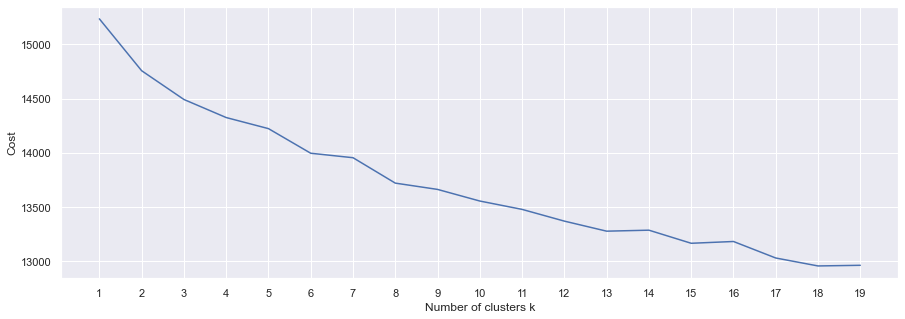

In [220]:
def elbow_method(data):
    total_variance = []
    for k in range(1, 20):
        kmeans = KMeans(n_clusters=k, init='k-means++')
        kmeans.fit(data)
        total_variance.append(kmeans.inertia_)   #Sum of distances of samples to their closest cluster center
    
    #visualization of the curve
    fig = plt.figure(figsize=(15, 5))
    plt.xticks(range(1,21))
    plt.plot(range(1, 20), total_variance)
    plt.grid(True)
    plt.xlabel('Number of clusters k')
    plt.ylabel('Cost')

elbow_method(d)

We decided to select 13 clusters based on the graph above

In [54]:
k = 13 #number of clusters

## K-Means

In [55]:
#we convert our initial dataframe d into an array for easier computation
vectors = np.array(d)

We first define some functions that will be then recalled inside the proper algorithm: this functions will be useful to determine the initial points of each cluster, compute the distance between each point and each cluster, in order to understand in which cluster that point has to be inserted, and, finally, compute the variance at each iteration of the algorthm in order to understand when the best cluster is achieved.

In [56]:
#fucntion that computes the euclidea distance between vectors 
def distance_between_products(x1,x2):
    return euclidean_distances(x1,x2)

In [61]:
'''function that assigns each point to a cluster. In input has:
- the centroids used in the specific iteration we are in
- the array 'vectors' that has as many rows as the unique products and as many columns as the significant words 
  that we have selected for the analysis
'''

def assign_points_to_clusters(centroids, vectors):
    clusters = []
    for i in range(vectors.shape[0]):
        distances = []
        for centroid in centroids:
            distance = distance_between_products([centroid], [vectors[i]])
            distances.append(distance)
            
        cluster_selected = [distances.index(min(distances)) + 1]    #to determine in which cluster to put that element
        clusters.append(cluster_selected)
    
    return clusters

In [58]:
'''function that calculates new centroids based on each cluster's mean'''

def define_new_centroids(clusters, vectors):
    new_centroids = []
    cluster_df = pd.concat([pd.DataFrame(vectors),pd.DataFrame(clusters, columns=['cluster'])], axis=1)
    
    for c in set(cluster_df['cluster']):
        
        current_cluster = cluster_df[cluster_df['cluster']==c][cluster_df.columns[:-1]]
        cluster_mean = current_cluster.mean(axis=0)
        new_centroids.append(cluster_mean)
    
    return new_centroids

In [59]:
'''function that calculates the variance within each cluster at each iteration'''

def variance(clusters, vectors):
    sum_squares = []
    cluster_df = pd.concat([pd.DataFrame(vectors),pd.DataFrame(clusters, columns=['cluster'])], axis=1)
    
    for c in set(cluster_df['cluster']):
        current_cluster = cluster_df[cluster_df['cluster']==c][cluster_df.columns[:-1]]
        cluster_mean = current_cluster.mean(axis=0)
        mean_repmat = np.matlib.repmat(cluster_mean, current_cluster.shape[0],1)
        sum_squares.append(np.sum(np.sum((current_cluster - mean_repmat)**2)))
    
    return sum_squares

### Initialization

In [64]:
cluster_variance = []

initial_centroids = random.sample(range(0, len(d)), k)    # I choose k numbers random between 0 and the length of our dataset

#we use these numbers as indices to get the products associated at those centroids
centroids = []      
for i in initial_centroids:
    centroids.append(vectors[i])
    
clusters = assign_points_to_clusters(centroids, vectors)
initial_clusters = clusters
print(0, round(np.mean(variance(clusters, vectors))))

0 1109.0


### Iterations

In [66]:
## ci mette circa 5 minuti a iterazione
for i in range(10):
    centroids = define_new_centroids(clusters, vectors)
    clusters = assign_clusters(centroids, vectors)
    cluster_var = np.mean(calc_centroid_variance(clusters, vectors))
    cluster_variance.append(cluster_var)
    print(i+1, round(cluster_var))

1 1076.0
2 1072.0
3 1069.0
4 1065.0
5 1056.0
6 1051.0
7 1044.0
8 1043.0
9 1042.0
10 1041.0


We can see that from the 7th iteration, the cluster variance pretty much stabilize, this means that the algorithm has found the best solution: the data points within each cluster stop changing.

We can visualize the change of viariance at each iteration from the graph below:

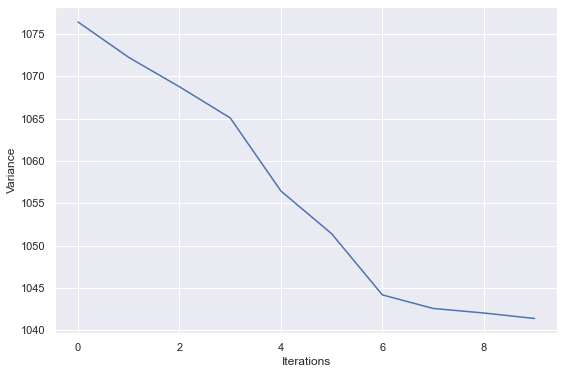

In [223]:
plt.subplots(figsize=(9,6))
plt.plot(cluster_variance)
plt.xlabel('Iterations')
plt.ylabel('Variance')
plt.show()

We can also determine which were the initial products selected as centroids:

In [98]:
for i in initial_centroids:
    print(d.index[i])

B004CH8342
B000FA68HY
B001I6NQAG
B000X4Q0XE
B0005YLUDC
B006TACYS6
B005ZGR480
B003BL7GZW
B0048LUB9M
B0017AG5U6
B0048IC6HA
B000S16WU8
B004LCAJKO


In [81]:
cluster_list = [cluster for list in clusters for cluster in list]

In [100]:
df = pd.DataFrame(list(reviews_per_product.items()),columns = ['ProductID','list_of_words']) 
df['cluster'] = cluster_list

We want to see now, how many products we have in each cluster:

In [91]:
df.groupby('cluster').count()

,ProductID,list_of_words
cluster,,
1,3363,3363
2,48767,48767
3,5343,5343
4,3080,3080
5,1000,1000
6,1856,1856
7,1699,1699
8,473,473
9,94,94


## Analysis of the clusters

Since we can retrieve the product Id of the prooducts inside the same cluster, we can now analyze the clusters a little bit deeper.

To do so we need to import the original dataset

In [218]:
data = pd.read_csv('Reviews.csv')
data.drop('Id', axis = 1, inplace = True)
data.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### 1. Identify the kind of products in the cluster (e.g., chips, tea, coffee) using a word cloud.

### 2. Provide the number of product in each cluster:
We have already answered this question above, when we grouped by the products based on the cluster they belonged. We are going to show again the final result here:

In [107]:
df.groupby('cluster').count()

,ProductID,list_of_words
cluster,,
1,3363,3363
2,48767,48767
3,5343,5343
4,3080,3080
5,1000,1000
6,1856,1856
7,1699,1699
8,473,473
9,94,94


As we can see, the algorithm that has the majoriry of products associated to, is **cluster number 2** which corrresponds to the following product IDs:

In [145]:
df[df.cluster == 2].ProductID

0        B001E4KFG0
2        B000LQOCH0
3        B000UA0QIQ
4        B006K2ZZ7K
6        B00171APVA
            ...    
74250    B005ZC0RRO
74252    B006T7TKZO
74255    B003S1WTCU
74256    B004I613EE
74257    B001LR2CU2
Name: ProductID, Length: 48767, dtype: object

### 3. Compute the reviews' score distribution in each cluster. Once you get them, test if their mean differences are statistically significant

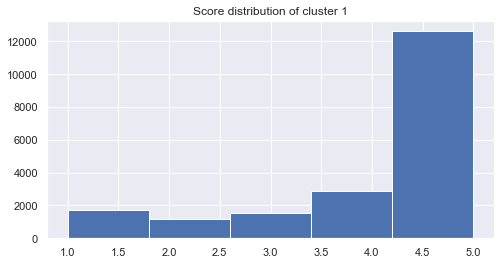

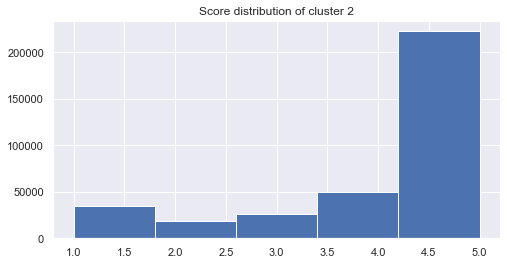

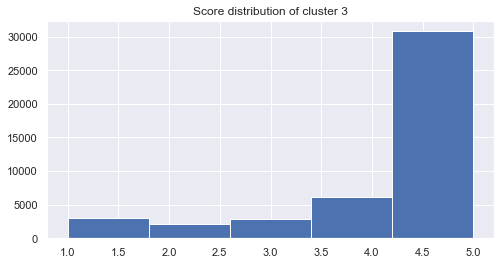

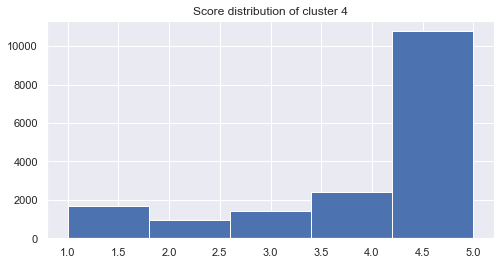

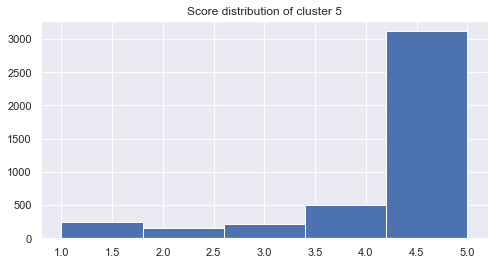

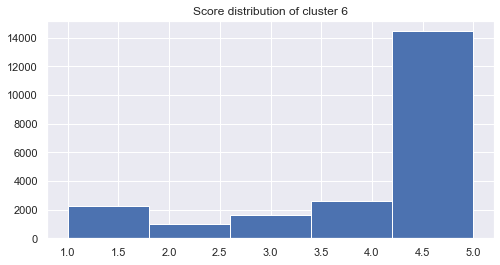

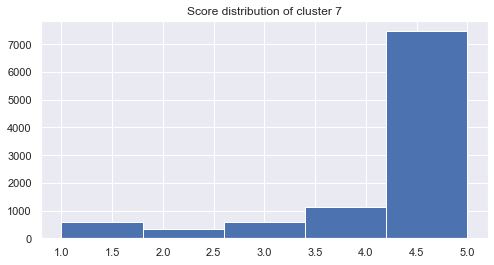

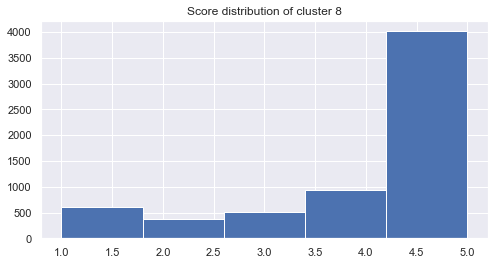

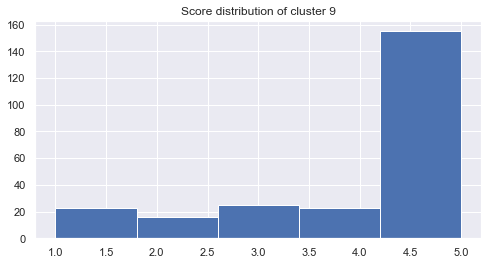

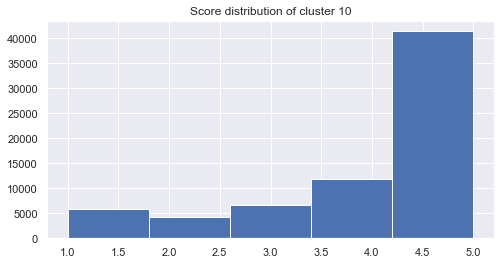

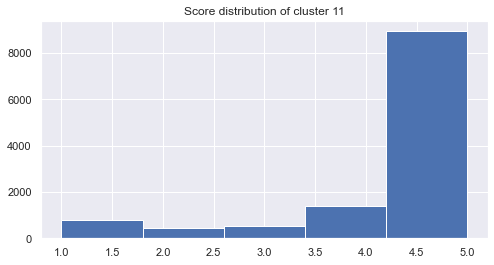

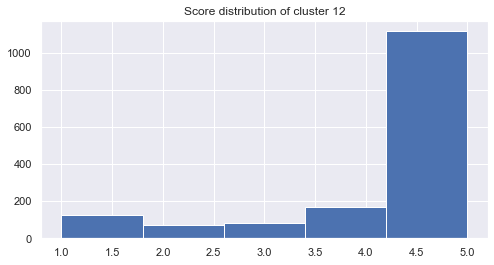

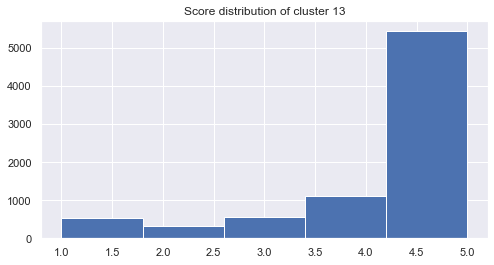

In [209]:
k = 13      #number of clusters

score_means = []

for i in range(k):
    
    l = list(df[df.cluster == i+1].ProductID)               #list of ProductId's inside cluster i+1
    
    d_l = data[data['ProductId'].isin(l)]                   #selecting only the rows of the original dataframe
                                                             #that conatin the reviews for those particular products
    score_means.append(d_l.Score.mean())
    
    #plot
    d_l.Score.hist(bins=5)
    plt.title(f'Score distribution of cluster {i+1}')
    plt.show()

In [217]:
for i in range(1,len(score_means)+1):
    print(f'mean of scores in cluster {i}: {round(score_means[i-1],3)}')

print(f'\nThe maximum value is: {round(max(score_means),3)} while the minimum is: {round(min(score_means),3)}')

mean of scores in cluster 1: 4.173
mean of scores in cluster 2: 4.156
mean of scores in cluster 3: 4.327
mean of scores in cluster 4: 4.136
mean of scores in cluster 5: 4.441
mean of scores in cluster 6: 4.185
mean of scores in cluster 7: 4.445
mean of scores in cluster 8: 4.144
mean of scores in cluster 9: 4.12
mean of scores in cluster 10: 4.131
mean of scores in cluster 11: 4.419
mean of scores in cluster 12: 4.336
mean of scores in cluster 13: 4.335

The maximum value is: 4.445 while the minimum is: 4.12


As we can see, although the number of products in each cluster in extremely different, the mean of the scores that the users give to the products in each cluster is basically the same, and is a very high value, always greater than 4

### 4. Get the number of unique users writing reviews in each cluster 

In [177]:
k = 13      #number of clusters

for i in range(k):
    
    l = list(df[df.cluster == i+1].ProductID)                   #list of ProductId's inside cluster i+1
    
    d_l = data[data['ProductId'].isin(l)]                       #selecting only the rows of the original dataframe
                                                                  #that conatin the reviews for those particular products
    
    number_of_users = len(d_l.UserId.unique())                  #number of unique users in those rows selected 
    
    print(f'number of unique users writing reviews in cluster {i+1}: {number_of_users}')

number of unique users writing reviews in cluster 1: 10878
number of unique users writing reviews in cluster 2: 175626
number of unique users writing reviews in cluster 3: 22916
number of unique users writing reviews in cluster 4: 12218
number of unique users writing reviews in cluster 5: 2474
number of unique users writing reviews in cluster 6: 8718
number of unique users writing reviews in cluster 7: 7823
number of unique users writing reviews in cluster 8: 3767
number of unique users writing reviews in cluster 9: 200
number of unique users writing reviews in cluster 10: 31982
number of unique users writing reviews in cluster 11: 7635
number of unique users writing reviews in cluster 12: 1409
number of unique users writing reviews in cluster 13: 6317
